In [1]:
!pip install tensorflow-addons
!pip install -q segmentation_models

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.1/612.1 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 2.3 MB/s eta 0:00:00


In [4]:
import pandas as pd, numpy as np, random,os
import tensorflow as tf, math
import tensorflow_addons as tfa
import tensorflow.keras.backend as K
import sklearn
import cv2
import matplotlib.pyplot as plt
import tensorflow_addons as tfa
import glob
import scipy
import warnings
from tensorflow.keras.utils import normalize
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import custom_object_scope
from sklearn.model_selection import train_test_split
from segmentation_models.base import functional as F
from tensorflow.keras.metrics import MeanIoU
from datetime import datetime

tfk = tf.keras
tfkl = tfk.layers
tfm = tf.math

# Set tf.keras as backend
os.environ['SM_FRAMEWORK'] = 'tf.keras'
import segmentation_models as sm


Segmentation Models: using `tf.keras` framework.


In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [31]:
SIZE = 256
num_images = 251

In [32]:
#Loading Image
image_names = glob.glob("/content/drive/MyDrive/segmentation/joint dataset/joint dataset final/resized image/*.png")
image_names.sort()
image_names_subset = image_names[0:num_images]
images = [cv2.imread(img) for img in image_names_subset]
image_dataset = np.array(images)

#Loading Mask
mask_names = glob.glob("/content/drive/MyDrive/segmentation/joint dataset/joint dataset final/inverted joints/*.png")
mask_names.sort()
mask_names_subset = mask_names[0:num_images]
masks = [cv2.imread(mask, 0) for mask in mask_names_subset]
mask_dataset = np.array(masks)
mask_dataset = np.expand_dims(mask_dataset, axis = 3)

print("Image data shape is: ", image_dataset.shape)
print("Mask data shape is: ", mask_dataset.shape)

Image data shape is:  (251, 256, 256, 3)
Mask data shape is:  (251, 256, 256, 1)


In [33]:
#Normalize images
image_dataset = image_dataset /255.
mask_dataset = mask_dataset /255.  #PIxel values will be 0 or 1

In [16]:
#split the data for traning and testing
X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset, test_size = 0.20, random_state = 42)

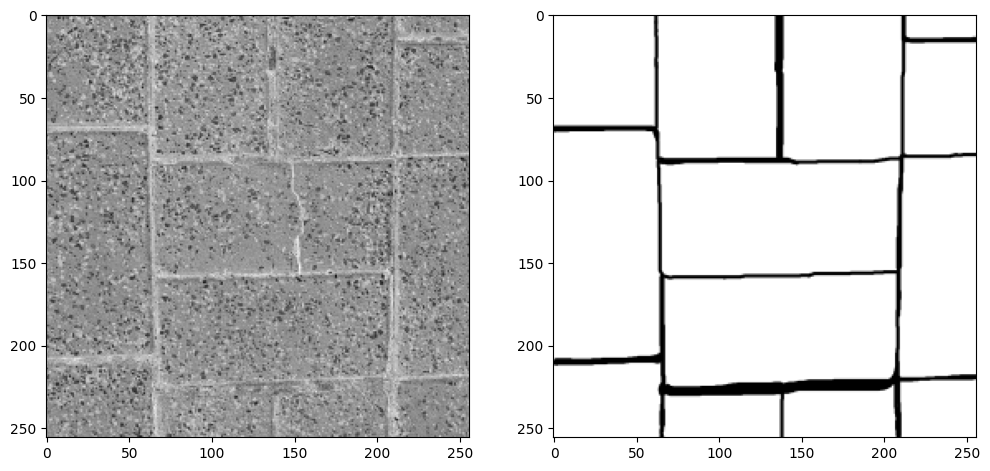

In [18]:
#Sanity check, view few mages
image_number = random.randint(0, len(X_train)-1)
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(X_train[image_number,:,:,0], cmap='gray')
plt.subplot(122)
plt.imshow(y_train[image_number,:,:,0], cmap='gray')

In [5]:
class CFG:
    # Model & Backbone
    model_name = "TransUNet"
    backbone = "ResNet50V2"

    # Seeding for reproducibility
    seed = 1

    # Image Size
    img_size = [256, 256]

    # Batch Size & Epochs
    batch_size = 16
    epochs = 50
    steps_per_execution = None

    # Loss & Optimizer & LR Scheduler
    loss =  "dice_loss"
    optimizer = "Adam"
    lr = 3e-4
    lr_schedule = "CosineDecay"
    patience = 5

In [6]:
def seeding(SEED):
    """
    Sets all random seeds for the program (Python, NumPy, and TensorFlow).
    """
    np.random.seed(SEED)
    random.seed(SEED)
    os.environ["PYTHONHASHSEED"] = str(SEED)
    os.environ["TF_CUDNN_DETERMINISTIC"] = str(SEED)
    tf.random.set_seed(SEED)
    print("seeding done!!!")


seeding(CFG.seed)

seeding done!!!


In [10]:
kwargs = {}
kwargs["backend"] = K  # set tensorflow.keras as backend


def dice_coef(y_true, y_pred):
    """Dice coefficient"""
    dice = F.f_score(
        y_true,
        y_pred,
        beta=1,
        smooth=1e-5,
        per_image=False,
        threshold=0.5,
        **kwargs,
    )
    return dice

# Register custom objects
custom_objs = {
    "dice_loss": sm.losses.dice_loss,
    "dice_coef": dice_coef,
    "precision": sm.metrics.precision,
    "recall": sm.metrics.recall,
    "IOU": sm.metrics.iou_score,
}
tf.keras.utils.get_custom_objects().update(custom_objs)


def get_lr_callback():
    if CFG.lr_schedule == "ReduceLROnPlateau":
        lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(
            monitor="val_loss",
            factor=0.1,
            patience=int(CFG.patience / 2),
            min_lr=CFG.lr / 1e2,
        )
    elif CFG.lr_schedule == "CosineDecay":
        lr_schedule = tf.keras.experimental.CosineDecay(
            initial_learning_rate=CFG.lr, decay_steps=CFG.epochs + 2, alpha=CFG.lr / 1e2
        )
        lr_schedule = tf.keras.callbacks.LearningRateScheduler(lr_schedule, verbose=0)
    elif CFG.lr_schedule == "ExponentialDecay":
        lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate=CFG.lr,
            decay_steps=CFG.epochs + 2,
            decay_rate=0.05,
            staircase=False,
        )
        lr_schedule = tf.keras.callbacks.LearningRateScheduler(lr_schedule, verbose=0)
    return lr_schedule




def apply_embedding_weights(target_layer, source_weights):
    """Apply embedding weights to a target layer.

    Args:
        target_layer: The target layer to which weights will
            be applied.
        source_weights: The source weights, which will be
            resized as necessary.
    """
    expected_shape = target_layer.weights[0].shape
    if expected_shape == source_weights.shape:
        grid = source_weights
    elif expected_shape[1] == source_weights.shape[1] - 1:
        grid = source_weights[:, 1:]
    else:
        _, grid = source_weights[0, :1], source_weights[0, 1:]
        sin = int(np.sqrt(grid.shape[0]))
        sout = int(np.sqrt(expected_shape[1]))
        warnings.warn(
            "Resizing position embeddings from " f"{sin} to {sout}",
            UserWarning,
        )
        zoom = (sout / sin, sout / sin, 1)
        grid = scipy.ndimage.zoom(grid.reshape(sin, sin, -1), zoom, order=1).reshape(
            1, sout * sout, -1
        )
    target_layer.set_weights([grid])


def load_weights_numpy(model, params_path):
    """Load weights saved using Flax as a numpy array.

    Args:
        model: A Keras model to load the weights into.
        params_path: Filepath to a numpy archive.
    """
    params_dict = np.load(
        params_path, allow_pickle=False
    )  # pylint: disable=unexpected-keyword-arg
    source_keys = list(params_dict.keys())

    source_keys_used = []
    n_transformers = len(
        set(
            "/".join(k.split("/")[:2])
            for k in source_keys
            if k.startswith("Transformer/encoderblock_")
        )
    )
    n_transformers_out = sum(
        l.name.startswith("Transformer/encoderblock_") for l in model.layers
    )
    assert n_transformers == n_transformers_out, (
        f"Wrong number of transformers ("
        f"{n_transformers_out} in model vs. {n_transformers} in weights)."
    )

    matches = []
    for tidx in range(n_transformers):
        encoder = model.get_layer(f"Transformer/encoderblock_{tidx}")
        source_prefix = f"Transformer/encoderblock_{tidx}"
        matches.extend(
            [
                {
                    "layer": layer,
                    "keys": [
                        f"{source_prefix}/{norm}/{name}" for name in ["scale", "bias"]
                    ],
                }
                for norm, layer in [
                    ("LayerNorm_0", encoder.layernorm1),
                    ("LayerNorm_2", encoder.layernorm2),
                ]
            ]
            + [
                {
                    "layer": encoder.mlpblock.get_layer(
                        f"{source_prefix}/Dense_{mlpdense}"
                    ),
                    "keys": [
                        f"{source_prefix}/MlpBlock_3/Dense_{mlpdense}/{name}"
                        for name in ["kernel", "bias"]
                    ],
                }
                for mlpdense in [0, 1]
            ]
            + [
                {
                    "layer": layer,
                    "keys": [
                        f"{source_prefix}/MultiHeadDotProductAttention_1/{attvar}/{name}"
                        for name in ["kernel", "bias"]
                    ],
                    "reshape": True,
                }
                for attvar, layer in [
                    ("query", encoder.att.query_dense),
                    ("key", encoder.att.key_dense),
                    ("value", encoder.att.value_dense),
                    ("out", encoder.att.combine_heads),
                ]
            ]
        )

    # Embedding kernel and bias
    matches.append(
        {
            "layer": model.get_layer("embedding"),
            "keys": [f"embedding/{name}" for name in ["kernel", "bias"]],
        }
    )

    matches.append(
        {
            "layer": model.get_layer("Transformer/encoder_norm"),
            "keys": [f"Transformer/encoder_norm/{name}" for name in ["scale", "bias"]],
        }
    )
    apply_embedding_weights(
        target_layer=model.get_layer("Transformer/posembed_input"),
        source_weights=params_dict["Transformer/posembed_input/pos_embedding"],
    )
    source_keys_used.append("Transformer/posembed_input/pos_embedding")
    for match in matches:
        source_keys_used.extend(match["keys"])
        source_weights = [params_dict[k] for k in match["keys"]]
        if match.get("reshape", False):
            source_weights = [
                source.reshape(expected.shape)
                for source, expected in zip(
                    source_weights, match["layer"].get_weights()
                )
            ]
        match["layer"].set_weights(source_weights)



class AddPositionEmbs(tfkl.Layer):
    """Adds (optionally learned) positional embeddings to the inputs."""

    def __init__(self, trainable=True, **kwargs):
        super().__init__(trainable=trainable, **kwargs)
        self.trainable = trainable

    def build(self, input_shape):
        assert (
            len(input_shape) == 3
        ), f"Number of dimensions should be 3, got {len(input_shape)}"
        self.pe = tf.Variable(
            name="pos_embedding",
            initial_value=tf.random_normal_initializer(stddev=0.06)(
                shape=(1, input_shape[1], input_shape[2] )
            ),
            dtype="float32",
            trainable=self.trainable,
        )

    def call(self, inputs):
        return inputs + tf.cast(self.pe, dtype=inputs.dtype)


class MultiHeadSelfAttention(tfkl.Layer):
    def __init__(self, *args, trainable=True, n_heads, **kwargs):
        super().__init__(trainable=trainable, *args, **kwargs)
        self.n_heads = n_heads

    def build(self, input_shape):
        hidden_size = input_shape[-1]
        n_heads = self.n_heads
        if hidden_size % n_heads != 0:
            raise ValueError(
                f"embedding dimension = {hidden_size} should be divisible by number of heads = {n_heads}"
            )
        self.hidden_size = hidden_size
        self.projection_dim = hidden_size // n_heads
        self.query_dense = tfkl.Dense(hidden_size, name="query")
        self.key_dense = tfkl.Dense(hidden_size, name="key")
        self.value_dense = tfkl.Dense(hidden_size, name="value")
        self.combine_heads = tfkl.Dense(hidden_size, name="out")

    # pylint: disable=no-self-use
    def attention(self, query, key, value):
        score = tf.matmul(query, key, transpose_b=True)
        dim_key = tf.cast(tf.shape(key)[-1], score.dtype)
        scaled_score = score / tf.math.sqrt(dim_key)
        weights = tf.nn.softmax(scaled_score, axis=-1)
        output = tf.matmul(weights, value)
        return output, weights

    def separate_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.n_heads, self.projection_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        query = self.query_dense(inputs)
        key = self.key_dense(inputs)
        value = self.value_dense(inputs)
        query = self.separate_heads(query, batch_size)
        key = self.separate_heads(key, batch_size)
        value = self.separate_heads(value, batch_size)

        attention, weights = self.attention(query, key, value)
        attention = tf.transpose(attention, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(attention, (batch_size, -1, self.hidden_size))
        output = self.combine_heads(concat_attention)
        return output, weights


class TransformerBlock(tfkl.Layer):
    """Implements a Transformer block."""

    def __init__(self, *args, n_heads, mlp_dim, dropout, trainable=True, **kwargs):
        super().__init__(*args, trainable=trainable, **kwargs)
        self.n_heads = n_heads
        self.mlp_dim = mlp_dim
        self.dropout = dropout

    def build(self, input_shape):
        self.att = MultiHeadSelfAttention(
            n_heads=self.n_heads,
            name="MultiHeadDotProductAttention_1",
        )
        self.mlpblock = tfk.Sequential(
            [
                tfkl.Dense(
                    self.mlp_dim, activation="linear", name=f"{self.name}/Dense_0"
                ),
                tfkl.Lambda(lambda x: tfk.activations.gelu(x, approximate=False))
                if hasattr(tfk.activations, "gelu")
                else tfkl.Lambda(lambda x: tfa.activations.gelu(x, approximate=False)),
                tfkl.Dropout(self.dropout),
                tfkl.Dense(input_shape[-1], name=f"{self.name}/Dense_1"),
                tfkl.Dropout(self.dropout),
            ],
            name="MlpBlock_3",
        )
        self.layernorm1 = tfkl.LayerNormalization(epsilon=1e-6, name="LayerNorm_0")
        self.layernorm2 = tfkl.LayerNormalization(epsilon=1e-6, name="LayerNorm_2")
        self.dropout = tfkl.Dropout(self.dropout)

    def call(self, inputs, training):
        x = self.layernorm1(inputs)
        x, weights = self.att(x)
        x = self.dropout(x, training=training)
        x = x + inputs
        y = self.layernorm2(x)
        y = self.mlpblock(y)
        return x + y, weights

def resnet_embeddings(x, image_size=224, n_skip=3):
    """Get resnet embeddings for Decoder"""
    resnet50v2 = tfk.applications.ResNet50V2(
        weights="imagenet", include_top=False, input_shape=(image_size, image_size, 3)
    )
    _ = resnet50v2(x)
    layers = ["conv3_block4_preact_relu", "conv2_block3_preact_relu", "conv1_conv"]
    features = []
    if n_skip > 0:
        for l in layers:
            features.append(resnet50v2.get_layer(l).output)
    return resnet50v2, features


L2_WEIGHT_DECAY = 1e-4


class SegmentationHead(tfkl.Layer):
    def __init__(
        self,
        name="seg_head",
        num_classes=9,
        kernel_size=1,
        final_act="sigmoid",
        **kwargs
    ):
        super(SegmentationHead, self).__init__(name=name, **kwargs)
        self.num_classes = num_classes
        self.kernel_size = kernel_size
        self.final_act = final_act

    def build(self, input_shape):
        self.conv = tfkl.Conv2D(
            filters=self.num_classes,
            kernel_size=self.kernel_size,
            padding="same",
            kernel_regularizer=tfk.regularizers.L2(L2_WEIGHT_DECAY),
            kernel_initializer=tfk.initializers.LecunNormal(),
        )
        self.act = tfkl.Activation(self.final_act)

    def call(self, inputs):
        x = self.conv(inputs)
        x = self.act(x)
        return x


class Conv2DReLu(tfkl.Layer):
    def __init__(self, filters, kernel_size, padding="same", strides=1, **kwargs):
        super().__init__(**kwargs)
        self.filters = filters
        self.kernel_size = kernel_size
        self.padding = padding
        self.strides = strides

    def build(self, input_shape):
        self.conv = tfkl.Conv2D(
            filters=self.filters,
            kernel_size=self.kernel_size,
            strides=self.strides,
            padding=self.padding,
            use_bias=False,
            kernel_regularizer=tfk.regularizers.L2(L2_WEIGHT_DECAY),
            kernel_initializer="lecun_normal",
        )

        self.bn = tfkl.BatchNormalization(momentum=0.9, epsilon=1e-5)

    def call(self, inputs):
        x = self.conv(inputs)
        x = self.bn(x)
        x = tf.nn.relu(x)
        return x


class DecoderBlock(tfkl.Layer):
    def __init__(self, filters, **kwargs):
        super().__init__(**kwargs)
        self.filters = filters

    def build(self, input_shape):
        self.conv1 = Conv2DReLu(filters=self.filters, kernel_size=3)
        self.conv2 = Conv2DReLu(filters=self.filters, kernel_size=3)
        self.upsampling = tfkl.UpSampling2D(size=2, interpolation="bilinear")

    def call(self, inputs, skip=None):
        x = self.upsampling(inputs)
        if skip is not None:
            x = tf.concat([x, skip], axis=-1)
        x = self.conv1(x)
        x = self.conv2(x)
        return x


class DecoderCup(tfkl.Layer):
    def __init__(self, decoder_channels, n_skip=3, **kwargs):
        super().__init__(**kwargs)
        self.decoder_channels = decoder_channels
        self.n_skip = n_skip

    def build(self, input_shape):
        self.conv_more = Conv2DReLu(filters=512, kernel_size=3)
        self.blocks = [DecoderBlock(filters=out_ch) for out_ch in self.decoder_channels]

    def call(self, hidden_states, features):
        x = self.conv_more(hidden_states)
        for i, decoder_block in enumerate(self.blocks):
            if features is not None:
                skip = features[i] if (i < self.n_skip) else None
            else:
                skip = None
            x = decoder_block(x, skip=skip)
        return x

def load_pretrained(model, pretrained_path):
    """Load model weights from a specified path in HDF5 format."""
    model.load_weights(pretrained_path)

custom_objects = {
    'AddPositionEmbs': AddPositionEmbs,
    'SegmentationHead': SegmentationHead,
    'MultiHeadSelfAttention': MultiHeadSelfAttention,
    'TransformerBlock': TransformerBlock,
    'Conv2DReLu': Conv2DReLu,
    'DecoderBlock': DecoderBlock,
    'DecoderCup': DecoderCup,
}


with custom_object_scope(custom_objects):
    def TransUNet(
        image_size=256,
        patch_size=16,
        hybrid=True,
        grid=(14, 14),
        resnet_n_layers=(3, 4, 9),
        hidden_size=384,
        n_layers=12,
        n_heads=12,
        mlp_dim=3072,
        dropout=0.1,
        decoder_channels=[256, 128, 64, 16],
        n_skip=3,
        num_classes=1,
        final_act="sigmoid",
        pretrain=True,
        freeze_enc_cnn=True,
        name="TransUNet",
    ):
        # Tranformer Encoder
        assert image_size % patch_size == 0, "image_size must be a multiple of patch_size"
        x = tf.keras.layers.Input(shape=(image_size, image_size, 3))

        #  CNN + Transformer
        if hybrid:
            grid_size = grid
            patch_size = image_size // 16 // grid_size[0]
            if patch_size == 0:
                patch_size = 1
            resnet50v2, features = resnet_embeddings(
                x, image_size=image_size, n_skip=n_skip
            )
            if freeze_enc_cnn:
                resnet50v2.trainable = False
            y = resnet50v2.get_layer("conv4_block6_preact_relu").output
            x = resnet50v2.input
        else:
            y = x
            features = None

        y = tfkl.Conv2D(
            filters=hidden_size,
            kernel_size=patch_size,
            strides=patch_size,
            padding="valid",
            name="embedding",
            trainable=not freeze_enc_cnn,
        )(y)
        y = tfkl.Reshape((y.shape[1] * y.shape[2], hidden_size))(y)
        y = AddPositionEmbs(name="Transformer/posembed_input", trainable=True)(y)

        y = tfkl.Dropout(0.1)(y)

        # Transformer/Encoder
        for n in range(n_layers):
            y, _ = TransformerBlock(
                n_heads=n_heads,
                mlp_dim=mlp_dim,
                dropout=dropout,
                name=f"Transformer/encoderblock_{n}",
                trainable=True,
            )(y)
        y = tfkl.LayerNormalization(epsilon=1e-6, name="Transformer/encoder_norm")(y)

        n_patch_sqrt = int(math.sqrt(y.shape[1]))

        y = tfkl.Reshape(target_shape=[n_patch_sqrt, n_patch_sqrt, hidden_size])(y)

        # Decoder
        if len(decoder_channels):
            y = DecoderCup(decoder_channels=decoder_channels, n_skip=n_skip)(y, features)

        # Segmentation Head
        y = SegmentationHead(num_classes=num_classes, final_act=final_act)(y)

        # Build Model
        model = tfk.models.Model(inputs=x, outputs=y, name=name)

        # Load Pretrain Weights
        if pretrain:
          pretrained_path = '/content/drive/MyDrive/Colab Notebooks/Final models/TransUnet_50_epochs_segmentation_v32023-07-27 21_21_44.300483.hdf5'
          load_pretrained(model, pretrained_path)

        return model

    def get_model(name=CFG.model_name, loss=CFG.loss, backbone=CFG.backbone):
        model = TransUNet(image_size=CFG.img_size[0], freeze_enc_cnn=False, pretrain=True)

        lr = CFG.lr
        if CFG.optimizer == "Adam":
            opt = tf.keras.optimizers.Adam(learning_rate=lr)
        elif CFG.optimizer == "AdamW":
            opt = tfa.optimizers.AdamW(learning_rate=lr, weight_decay=lr)
        elif CFG.optimizer == "RectifiedAdam":
            opt = tfa.optimizers.RectifiedAdam(learning_rate=lr)
        else:
            raise ValueError("Wrong Optimizer Name")

        model.compile(
            optimizer=opt,
            loss=loss,
            steps_per_execution=CFG.steps_per_execution, # to reduce idle time
            metrics=[
                dice_coef,
                "precision",
                "recall",
            ],
        )
        return model

In [11]:
model = get_model()
model.summary()

Model: "TransUNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_4[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                          

In [12]:
log_dir = "logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [ ]:
start3 = datetime.now()

model_history = model.fit(X_train, y_train,
                    verbose=1,
                    batch_size =CFG.batch_size,
                    validation_data=(X_test, y_test ),
                    shuffle=True,
                    epochs=CFG.epochs,
                    callbacks=[tensorboard_callback])

stop3 = datetime.now()
#Execution time of the model
execution_time_model = stop3-start3
print("Trans UNet execution time is: ", execution_time_model)

In [ ]:
%load_ext tensorboard
%tensorboard --logdir logs/fit

In [ ]:
#plot the training and validation accuracy and loss at each epoch
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
#IOU for each class is..
# IOU = true_positive / (true_positive + false_positive + false_negative).
y_pred=model.predict(X_test)
y_pred_thresholded = y_pred > 0.5
n_classes = 2
IOU_keras = MeanIoU(num_classes=n_classes)
IOU_keras.update_state(y_test,y_pred_thresholded)
print("Mean IoU =", IOU_keras.result().numpy())

values = np.array(IOU_keras.get_weights()).reshape(n_classes, n_classes)
class1_IoU = values[0,0]/(values[0,0] + values[0,1] + values[1,0])
class2_IoU = values[1,1]/(values[1,1] + values[1,0] + values[0,1])
precision = values[1,1]/(values[1,1] + values[0,1])
Recall = values[1,1]/(values[1,1] + values[1,0])
F1_score = 2 /((1/precision) + (1/Recall))
print("Precision =", precision *100)
print("Recall =", Recall*100)
print("F1-score =", F1_score*100)

In [ ]:
threshold = 0.5
test_img_number = random.randint(0, len(X_test)-1)
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
test_img_input=np.expand_dims(test_img, 0)
print(test_img_input.shape)
prediction = (model.predict(test_img_input)[0,:,:,0] > 0.5).astype(np.uint8)
print(prediction.shape)

plt.figure(figsize=(16, 15))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray')

plt.show()
